**This code is afrom BanditSystem import *dpoted from https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits**

In [276]:
from BanditSystem import *

In [141]:
import nengo
import numpy as np
import nengo_spa as spa
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm
%matplotlib inline

import scipy.stats as stats
import matplotlib

from matplotlib.animation import FuncAnimation

from IPython.core.pylabtools import figsize
norm = stats.norm
gamma = stats.gamma

# matplotlib setup
figsize(11.0, 10)
x = np.linspace(0.0,16.0,200)

In [272]:
def plot_pdf( trials, mean, variance, label, ymax = 0, set_height=False ):

  y = norm.pdf( x, mean, np.sqrt(variance) )

  p = plt.plot(x, y, lw=2, label = label )
  c = p[0].get_markeredgecolor()    
  plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
  plt.legend()
  plt.autoscale(tight=True)

  plt.vlines(mean, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    
  if ymax == 0: ymax = y[1:].max()*1.1     
    
  if set_height:
    axes = plt.gca()
    axes.set_ylim([-ymax,ymax])  
    axes.set_xlim([-10,10]) 
  
  return ymax


def plot_gamma( trials, alpha, beta, label, ymax = 0, precision = 0 ):

  variance = beta / (alpha + 1)
  
  y = stats.gamma.pdf(x, a=alpha, scale=1/beta)

  p = plt.plot(x, y, lw=2, label = f"var = {alpha/beta**2:.3f}" )
  c = p[0].get_markeredgecolor()  
  
  plt.fill_between(x, y, 0, color=c, alpha=0.2 )
  
  # if supplied, show the true precision
  if precision > 0:
    plt.vlines(x=[precision], ymin=0, ymax=(y[1:].max()*1.1), colors = c, linestyles = "--", lw = 2)
    
  plt.title(f"{trials} Trials - Mean Precision = {1/variance:.2f}")
  plt.legend() 
  plt.autoscale(tight=True)

  axes = plt.gca()
  axes.set_ylim([0,y[1:].max()*1.1]) 
  
figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,18.0,200)


def plot_socket_pdfs(sockets): 
  
  ymax = 0    
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its true values
    y = norm.pdf( x, socket.μ, np.sqrt(socket.v))

    p = plt.plot(x, y, lw=2, label = f"{index}" )
    c = p[0].get_markeredgecolor()    
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])          
  
  plt.legend(title = 'Sockets')
  plt.title('Density Plot of Socket Outputs')
  plt.xlabel('Socket Output (seconds of charge)')
  plt.ylabel('Density')   
  
  
def plot_socket( socket,name = "o.pdf", ymax = 0, title = None):
  ymax1 = plot_pdf( socket.n, socket.μ, socket.v, "True", ymax )  
  ymax2 = plot_pdf( socket.n, socket.μ_0, socket.v_0, "Estimated", ymax )  
  
  if title is None: title = f"{socket.n} Trials"        
  plt.title(title)
    
  # if no vertical extent is set automatically add space at top
  # - chooses the max from the 2 plots and adds 5%
  if ymax == 0: ymax = max(ymax1,ymax2)*1.05  
  axes = plt.gca()
  axes.set_ylim([0,ymax])    
  plt.savefig(name,bbox_inches='tight') 
  

def plot_sockets(sockets, socket_probabilities ):
    
  trials = sum([socket.n for socket in sockets])           
  plt.title(f"{trials} Trials")    
  
  ymax = 0    
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its estimates
    y = norm.pdf( x, socket.μ_0, np.sqrt(socket.v_0) )
    
    p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
    c = p[0].get_markeredgecolor()    
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )    
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ_0, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)    

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])    

In [227]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self,v):                
                
        self.τ_0 = 0.0001  # the estimated posterior precision
        self.μ_0 = 1   # the estimated posterior mean

        self.v = v  
        # pass the true reward value to the base PowerSocket             
        super().__init__(v)         
        
    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0  
   
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """   

        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1       

In [264]:
methods = []
rewards = []
mean_rewards = []

def run_multiple_tests( tester, max_steps = 10, show_socket_percentages = True ):
    np.random.seed(18945)
    number_of_tests = 338
    number_of_steps = max_steps
    maximum_total_reward = 30

    experiment = SocketExperiment(socket_tester   = tester,
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps,
                                  maximum_total_reward = maximum_total_reward)
    experiment.run()

    print(f'Mean Reward per Time Step = {experiment.get_mean_total_reward():0.4f}')
    print(f'Optimal Socket Selected = {experiment.get_optimal_selected():0.4f}')    
    print(f'Average Number of Trials Per Run = {experiment.get_mean_time_steps():0.4f}')
    if show_socket_percentages:
      print(f'Socket Percentages = {experiment.get_socket_percentages()}') 
        
    rewards.append(experiment.get_cumulative_reward_per_timestep())        
    mean_rewards.append(f"{experiment.get_mean_total_reward():0.4f}")

In [265]:
# Thompson Sampling
run_multiple_tests( SocketTester( GaussianThompsonSocket ))

Mean Reward per Time Step = 0.4360
Optimal Socket Selected = 0.5585
Average Number of Trials Per Run = 9.0000
Socket Percentages = [0.441 0.559]


In [262]:
class UnknownMeanUnknownVariance:
    np.random.seed(18945)
    def __init__(self, μ, v):       
      self.μ = μ   # the true mean 
      self.v = v   # the true variance
                      
      self.n = 0   # the number of times this socket has been tried
      self.x = []  # list of all samples
               
      self.α = 0   # gamma shape parameter  
      self.β = 0  # gamma rate parameter  
      
      self.μ_0 = 1 # the prior (estimated) mean
      self.v_0 = self.β / (self.α + 1) # the prior (estimated) variance             
                    
    def update(self,x):        
      ''' increase the number of times this socket has been used and improve the estimate of the 
          mean and variance by combining the single new value 'x' with the current estimate '''
      n = 1
      v = self.n
      
      self.α = self.α + n/2     
      self.β = self.β + ((n*v/(v + n)) * (((x - self.μ_0)**2)/2))
      
      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)      
            
      self.x.append(x)  # append the new value to the list of samples 
      self.n += 1
      self.μ_0 = np.array(self.x).mean()          
        
    def charge(self):
      ''' return a value using the true mean and variance for the socket '''              
      value = np.random.normal( self.μ, np.sqrt(self.v) )
      
      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value      
    
    def sample(self):  
      ''' sample from our estimated normal '''                   
      
      precision = np.random.gamma(self.α, 1/self.β)
      if precision == 0 or self.n == 0: precision = 0.001
      
      estimated_variance = 1/precision
      return np.random.normal( self.μ_0, np.sqrt(estimated_variance))

/Users/sixuanchen/miniforge3/envs/work/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sixuanchen/miniforge3/envs/work/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


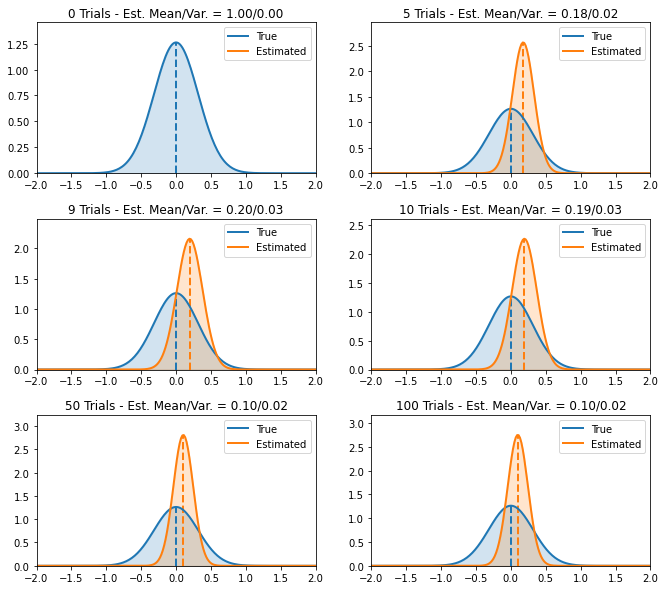

In [273]:
''' set the default values to use for the test socket '''
mean = 0
variance = 0.1
socket =  UnknownMeanUnknownVariance( mean, variance )

draw_samples = [0, 5, 4, 1, 40, 50]
x = np.linspace(-2.0,2.0,200)

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    reward = socket.charge()
    socket.update(reward)          

  title = f"{socket.n} Trials - Est. Mean/Var. = {socket.μ_0:0.2f}/{socket.v_0:.2f}"  
  plot_socket( socket,name="Original.pdf", title = title )
    


In [223]:
class Approcimated_UnknownMeanUnknownVariance():
    np.random.seed(18945)
  
    def __init__(self,μ,v):       
      self.μ = μ   # the true mean 
      self.v = v   # the true variance
                      
      self.n = 0   # the number of times this socket has been tried
      self.x = []  # list of all samples
               
      self.α = 0   # gamma shape parameter  
      self.β = 0  # gamma rate parameter  
      
      self.μ_0 = 1 # the prior (estimated) mean
      self.v_0 = self.β / (self.α + 1) # the prior (estimated) variance   
           
                    
    def update(self,x):        
      ''' increase the number of times this socket has been used and improve the estimate of the 
          mean and variance by combining the single new value 'x' with the current estimate '''
      n = 1
      v = self.n
      
      self.α = v* n/2     
      self.β = v*(((n*v/(v + n)) * (((x - self.μ_0)**2)/2)))
      
      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)      
            
      self.x.append(x)  # append the new value to the list of samples 
      self.n += 1
      self.μ_0 = np.array(self.x).mean()          
        
    def charge(self):
      ''' return a value using the true mean and variance for the socket '''              
      value = np.random.normal( self.μ, np.sqrt(self.v) )
      
      # never allow a charge less than 0 to be returned
      return value      
    
    def sample(self,t):  
      ''' sample from our estimated normal '''                   
      
      precision = np.random.gamma(self.α, 1/self.β)
      if precision == 0 or self.n == 0: precision = 1
      
      estimated_variance = 1/precision
      return np.random.normal( self.μ_0, np.sqrt(estimated_variance))

/Users/sixuanchen/miniforge3/envs/work/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/sixuanchen/miniforge3/envs/work/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


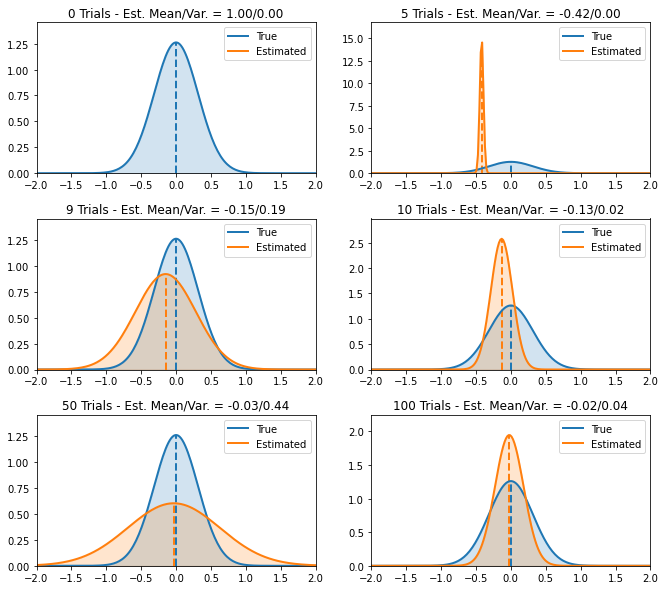

In [274]:
''' set the default values to use for the test socket '''
mean = 0
variance = 0.1
socket =  Approcimated_UnknownMeanUnknownVariance( mean, variance )

draw_samples = [0, 5, 4, 1, 40, 50]
x = np.linspace(-2.0,2.0,200)

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)         
  plt.subplots_adjust(hspace = 0.3)
  
  for k in range(i):          
    reward = socket.charge()
    socket.update(reward)          

  title = f"{socket.n} Trials - Est. Mean/Var. = {socket.μ_0:0.2f}/{socket.v_0:.2f}"  
  plot_socket( socket, name = "Approcimated.pdf", title = title )
    
